In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
import pack_ga
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
local
stop final relax at some point


stop final relax at some point
Generation 0, Trees 40, Best cost: 0.45377487, Est: 1.13443718, h: 6.496267


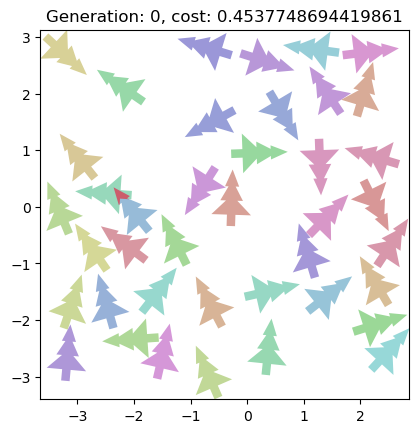

[[13], [2], [24], [18]]
Generation 1, Trees 40, Best cost: 0.42387125, Est: 1.05967808, h: 6.470082


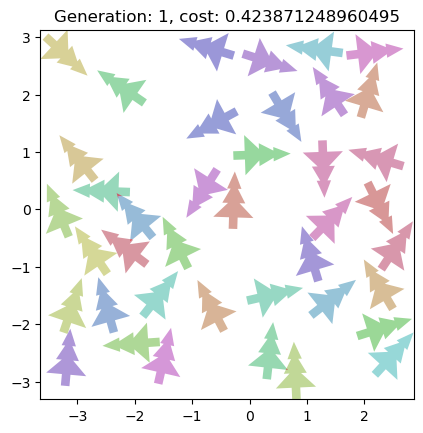

[[13], [13], [13], [13]]
Generation 2, Trees 40, Best cost: 0.41791213, Est: 1.04478035, h: 6.450901


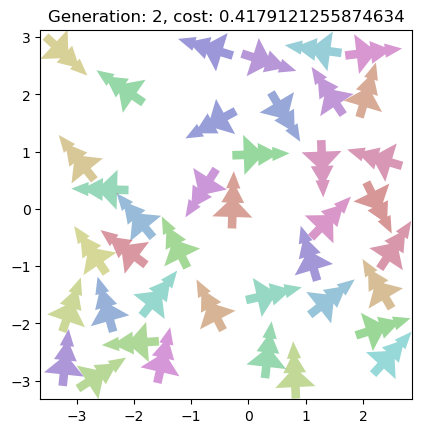

[[13], [13], [13], [13]]
Generation 3, Trees 40, Best cost: 0.41456643, Est: 1.03641605, h: 6.432744


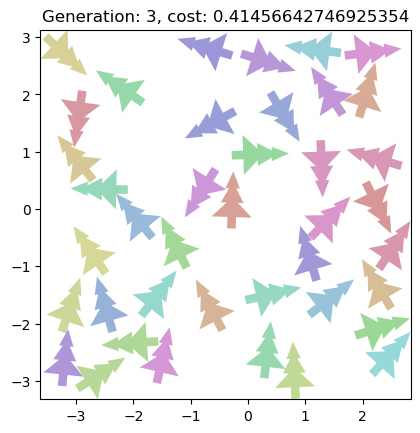

[[13], [13], [13], [13]]
Generation 4, Trees 40, Best cost: 0.40933871, Est: 1.02334681, h: 6.373887


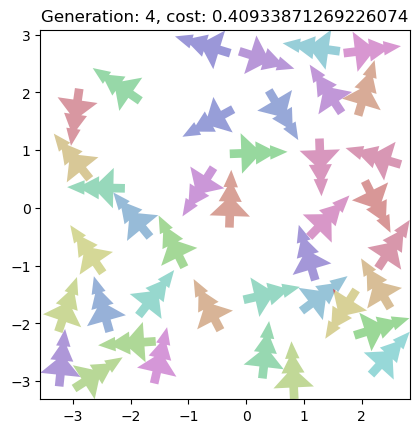

[[13], [13], [13], [13]]
Generation 5, Trees 40, Best cost: 0.40536267, Est: 1.01340666, h: 6.357935


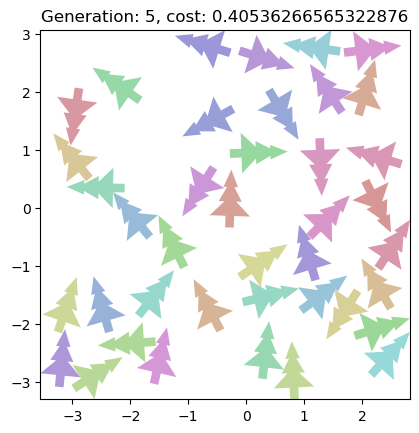

[[13], [13], [13], [13]]
Generation 6, Trees 40, Best cost: 0.40281999, Est: 1.00704994, h: 6.339263


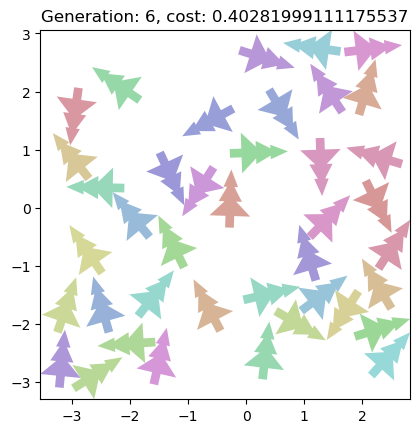

[[13], [13], [13], [13]]
Generation 7, Trees 40, Best cost: 0.40078887, Est: 1.00197220, h: 6.323567


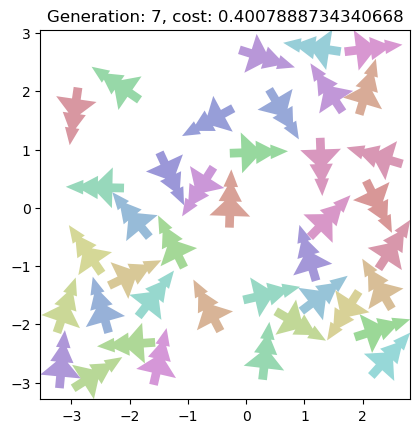

[[13], [13], [13], [13]]
Generation 8, Trees 40, Best cost: 0.39877614, Est: 0.99694033, h: 6.307679


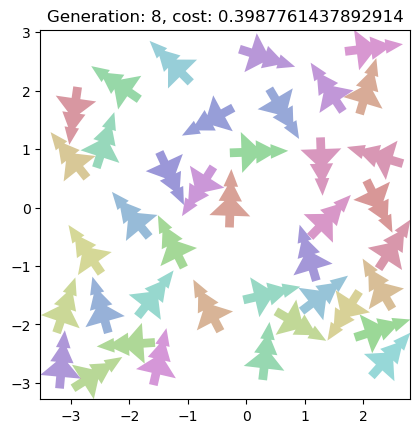

[[13], [13], [13], [13]]
Generation 9, Trees 40, Best cost: 0.39580566, Est: 0.98951416, h: 6.283902


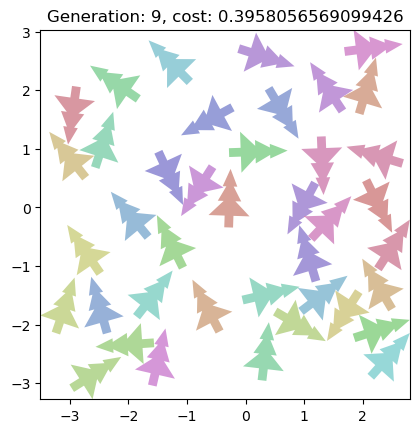

[[13], [13], [13], [13]]
Generation 10, Trees 40, Best cost: 0.39305967, Est: 0.98264914, h: 6.264356


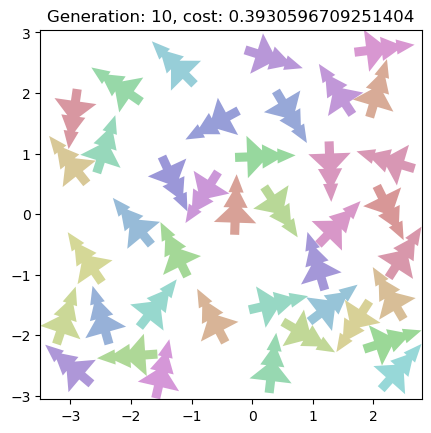

[[13], [13], [13], [13]]
Generation 11, Trees 40, Best cost: 0.38967362, Est: 0.97418404, h: 6.236633


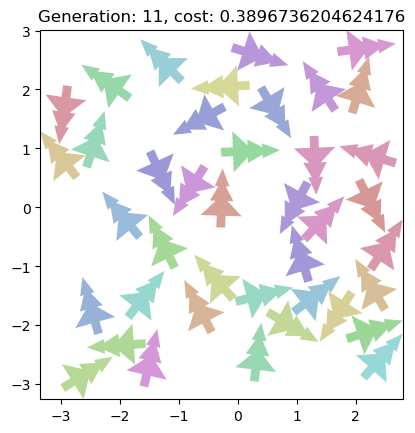

[[13], [13], [13], [13]]
Generation 12, Trees 40, Best cost: 0.38712695, Est: 0.96781740, h: 6.216842


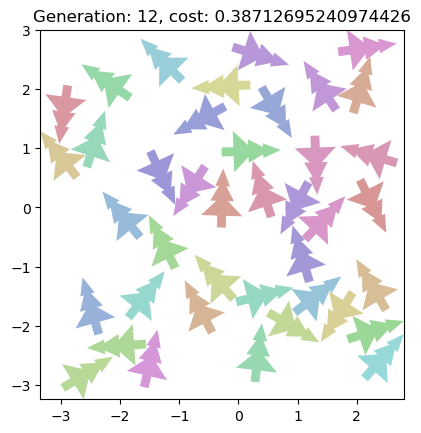

[[13], [13], [13], [13]]
Generation 13, Trees 40, Best cost: 0.37969643, Est: 0.94924107, h: 6.147469


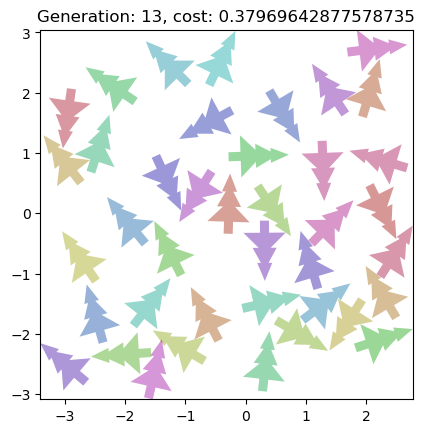

[[13], [13], [13], [13]]
Generation 14, Trees 40, Best cost: 0.37629449, Est: 0.94073620, h: 6.129068


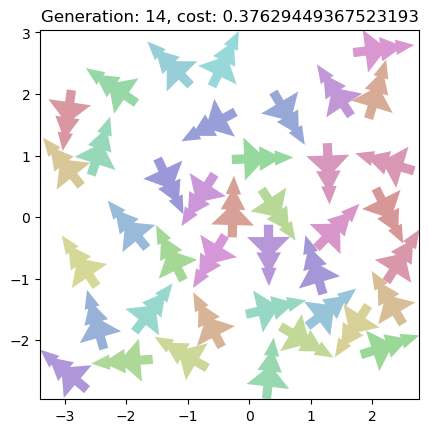

[[13], [13], [13], [13]]
Generation 15, Trees 40, Best cost: 0.37413940, Est: 0.93534851, h: 6.111236


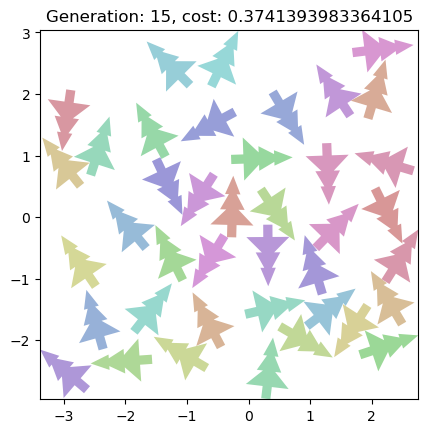

[[13], [13], [13], [13]]
Generation 16, Trees 40, Best cost: 0.37211275, Est: 0.93028183, h: 6.094420


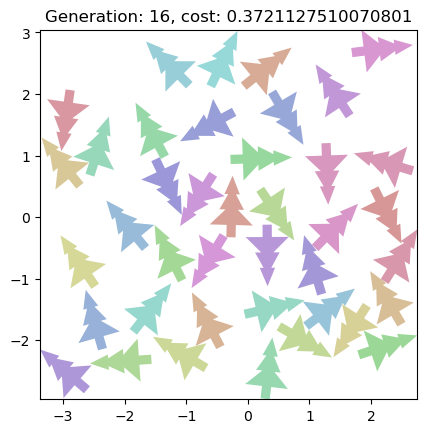

[[13], [13], [13], [13]]
Generation 17, Trees 40, Best cost: 0.36831358, Est: 0.92078400, h: 6.059905


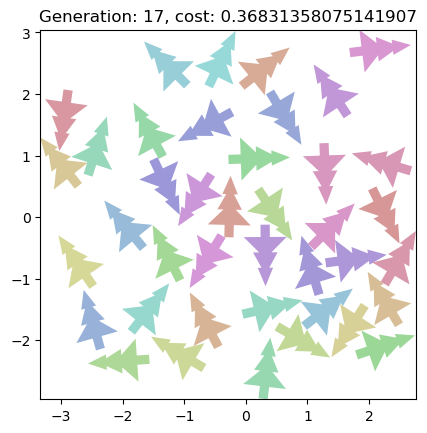

[[13], [13], [13], [13]]
Generation 18, Trees 40, Best cost: 0.36710444, Est: 0.91776114, h: 6.053133


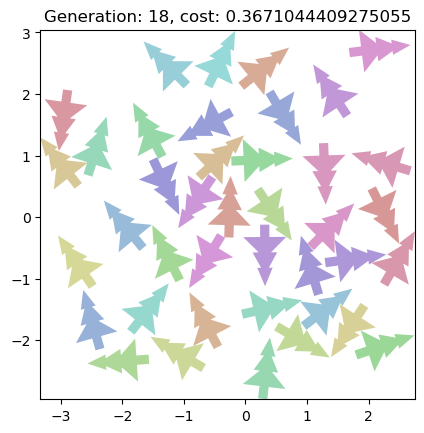

[[13], [13], [13], [13]]
Generation 19, Trees 40, Best cost: 0.36435330, Est: 0.91088324, h: 6.030428


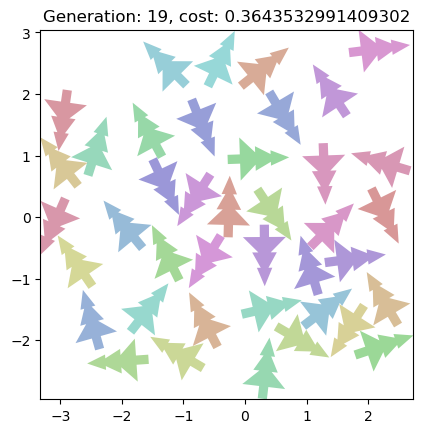

[[13], [13], [13], [13]]
Generation 20, Trees 40, Best cost: 0.36161473, Est: 0.90403681, h: 6.007285


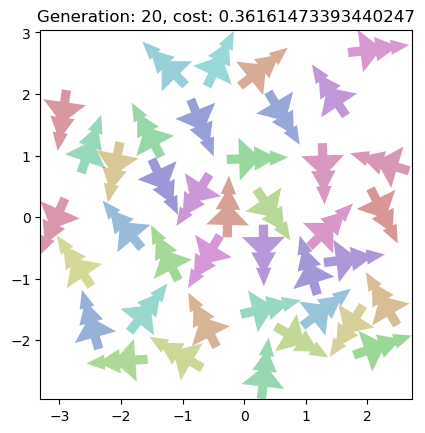

[[13], [13], [13], [13]]
Generation 21, Trees 40, Best cost: 0.35929114, Est: 0.89822788, h: 5.989235


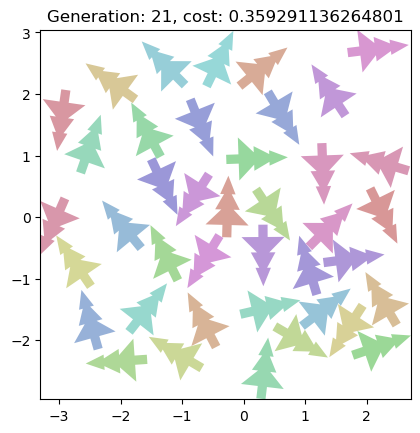

[[13], [13], [13], [13]]
Generation 22, Trees 40, Best cost: 0.35757071, Est: 0.89392681, h: 5.974034


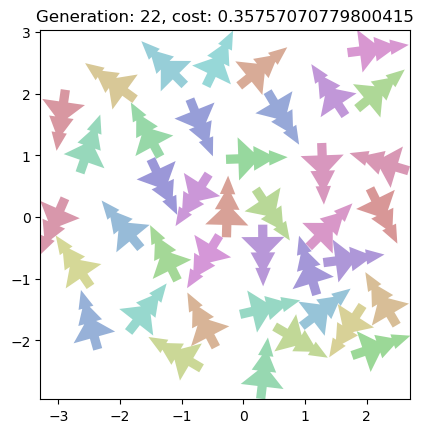

[[13], [13], [13], [13]]
Generation 23, Trees 40, Best cost: 0.35591245, Est: 0.88978109, h: 5.959463


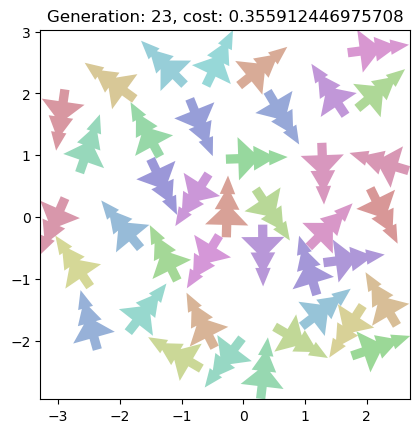

[[13], [13], [13], [13]]
Generation 24, Trees 40, Best cost: 0.35429221, Est: 0.88573055, h: 5.940214


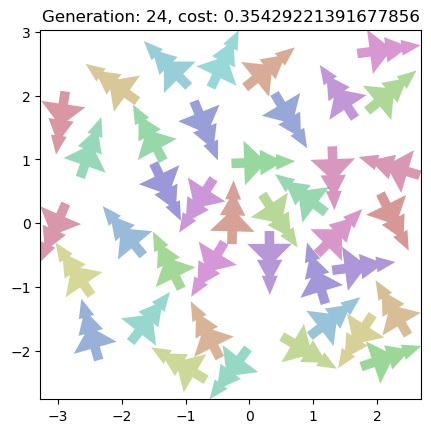

[[13], [13], [13], [13]]
Generation 25, Trees 40, Best cost: 0.35050318, Est: 0.87625790, h: 5.910496


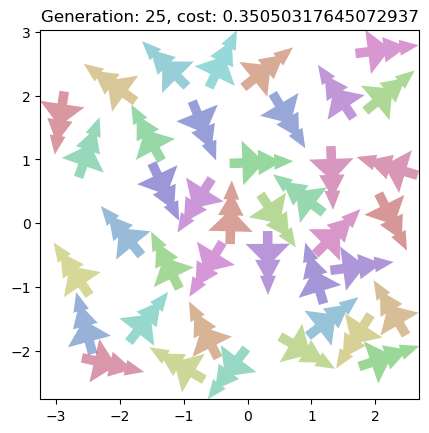

[[13], [13], [13], [13]]
Generation 26, Trees 40, Best cost: 0.34811619, Est: 0.87029047, h: 5.894419


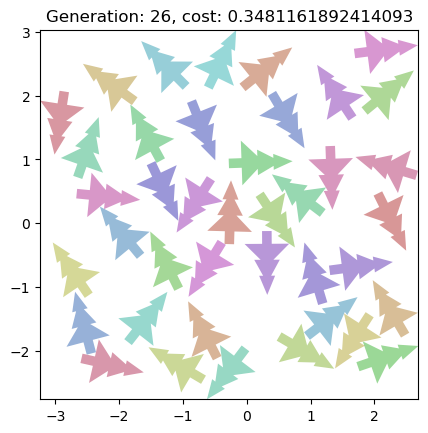

[[13], [13], [13], [13]]
Generation 27, Trees 40, Best cost: 0.34620509, Est: 0.86551275, h: 5.878488


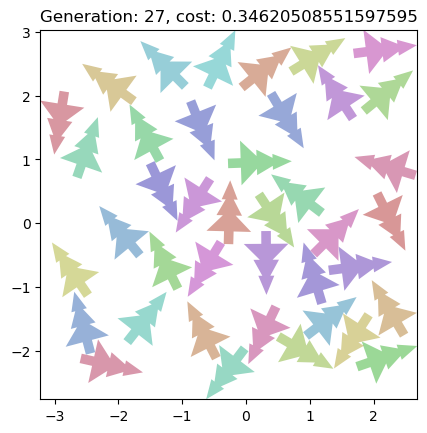

[[13], [13], [13], [13]]
Generation 28, Trees 40, Best cost: 0.33672446, Est: 0.84181118, h: 5.796903


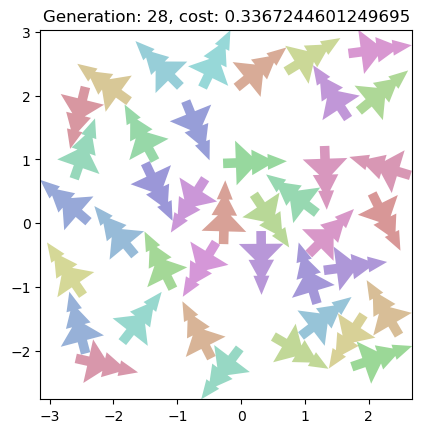

[[13], [13], [13], [13]]
Generation 29, Trees 40, Best cost: 0.33514008, Est: 0.83785019, h: 5.783313


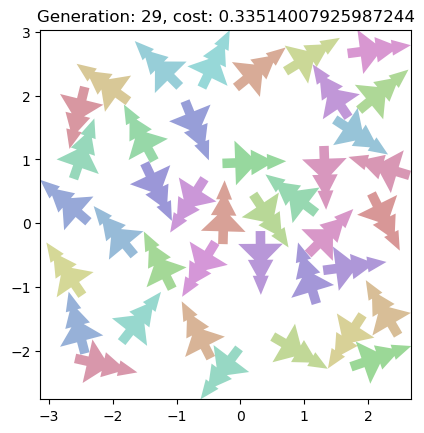

[[13], [13], [13], [13]]
Generation 30, Trees 40, Best cost: 0.33371463, Est: 0.83428659, h: 5.769616


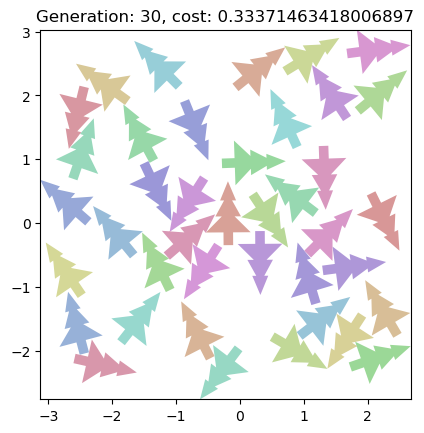

[[13], [13], [13], [13]]
Generation 31, Trees 40, Best cost: 0.33033291, Est: 0.82583227, h: 5.737422


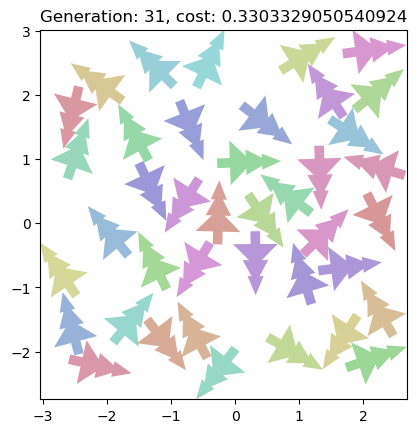

[[13], [13], [13], [13]]
Generation 32, Trees 40, Best cost: 0.32771567, Est: 0.81928921, h: 5.718164


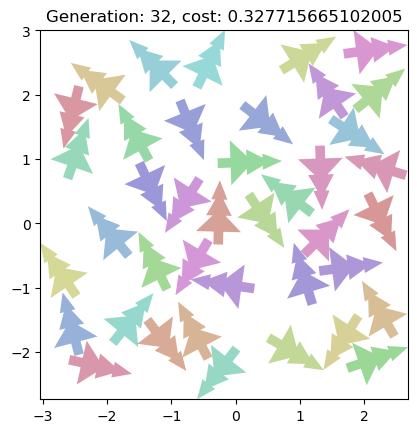

[[13], [13], [13], [13]]
Generation 33, Trees 40, Best cost: 0.32591388, Est: 0.81478472, h: 5.702760


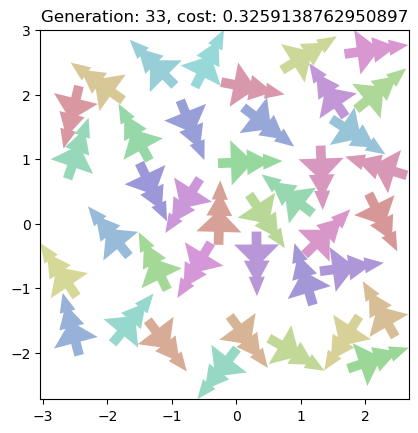

[[13], [13], [13], [13]]
Generation 34, Trees 40, Best cost: 0.32447359, Est: 0.81118393, h: 5.688818


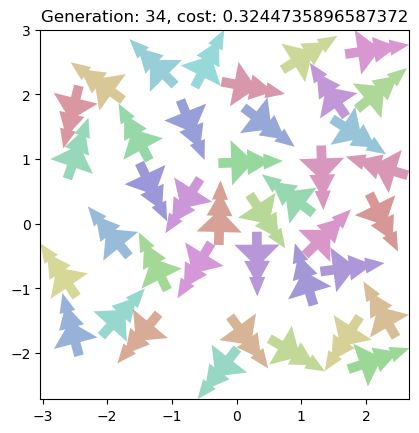

[[13], [13], [13], [13]]
Generation 35, Trees 40, Best cost: 0.32282960, Est: 0.80707397, h: 5.675568


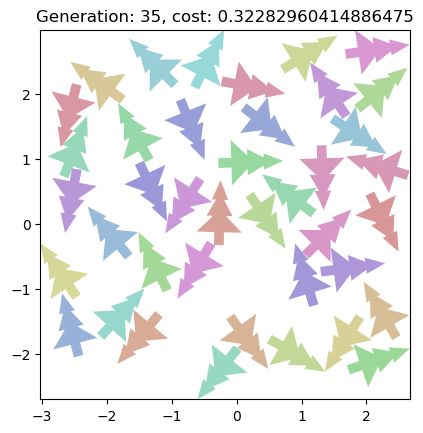

[[13], [13], [13], [13]]
Generation 36, Trees 40, Best cost: 0.32135126, Est: 0.80337811, h: 5.662413


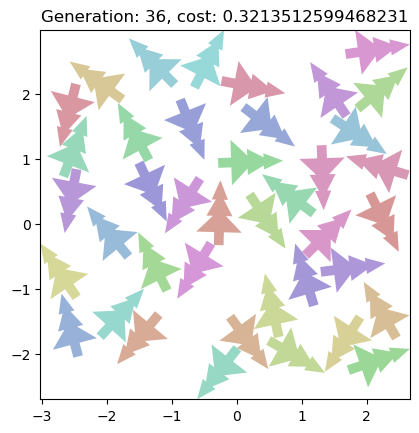

[[13], [13], [13], [13]]
Generation 37, Trees 40, Best cost: 0.31939533, Est: 0.79848833, h: 5.645113


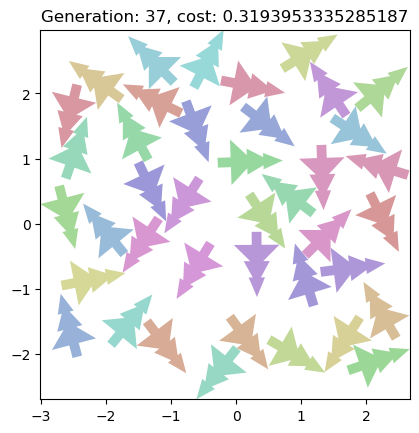

[[13], [13], [13], [13]]
Generation 38, Trees 40, Best cost: 0.31789923, Est: 0.79474807, h: 5.631994


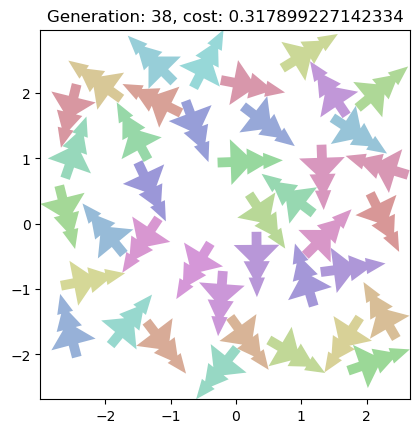

[[13], [13], [13], [13]]
Generation 39, Trees 40, Best cost: 0.31644994, Est: 0.79112487, h: 5.616545


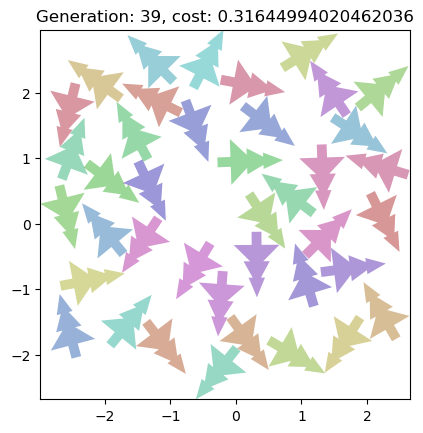

[[13], [13], [13], [13]]
Generation 40, Trees 40, Best cost: 0.31460309, Est: 0.78650770, h: 5.602623


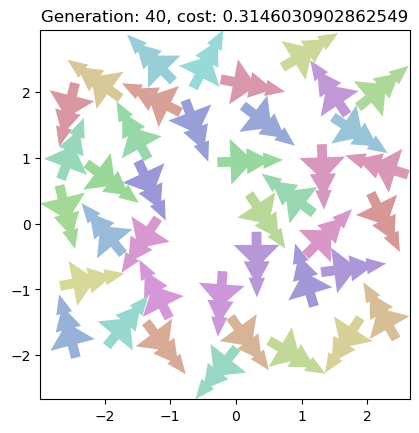

[[13], [13], [13], [13]]
Generation 41, Trees 40, Best cost: 0.31300110, Est: 0.78250275, h: 5.588935


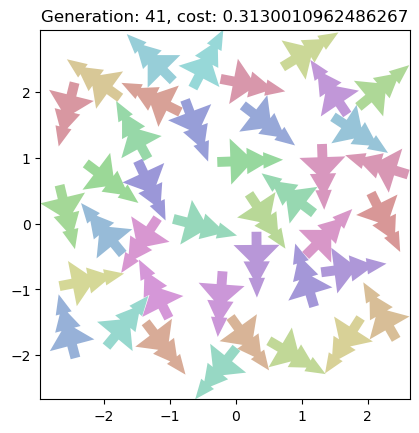

[[13], [13], [13], [13]]
Generation 42, Trees 40, Best cost: 0.31150985, Est: 0.77877464, h: 5.575655


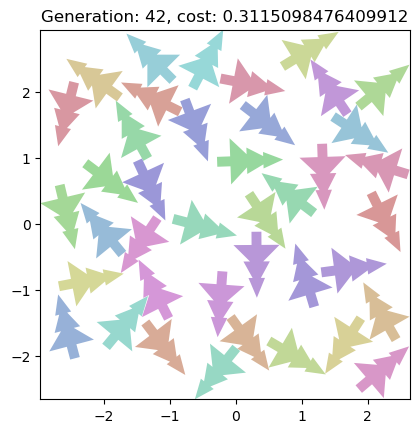

[[13], [13], [13], [13]]
Generation 43, Trees 40, Best cost: 0.30937055, Est: 0.77342639, h: 5.555077


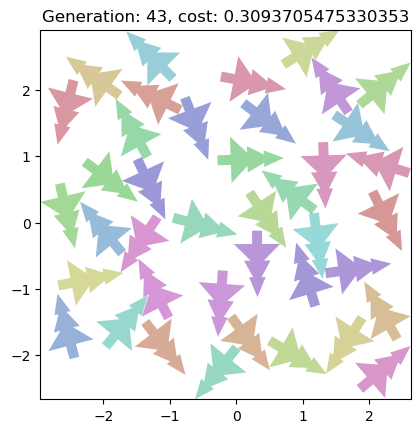

[[13], [13], [13], [13]]
Generation 44, Trees 40, Best cost: 0.30809653, Est: 0.77024131, h: 5.541227


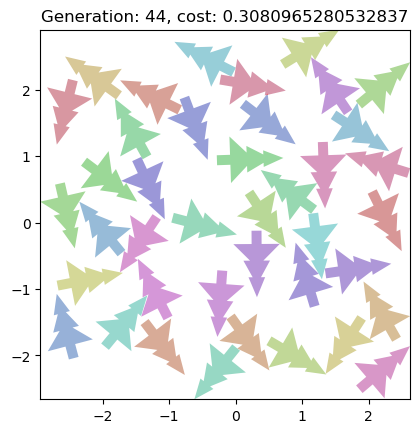

[[13], [13], [13], [13]]
Generation 45, Trees 40, Best cost: 0.30634552, Est: 0.76586380, h: 5.527797


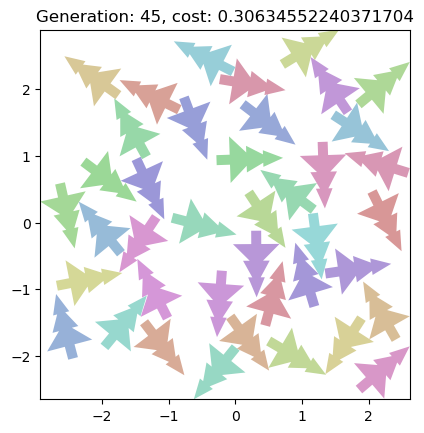

[[13], [13], [13], [13]]
Generation 46, Trees 40, Best cost: 0.30443269, Est: 0.76108174, h: 5.510972


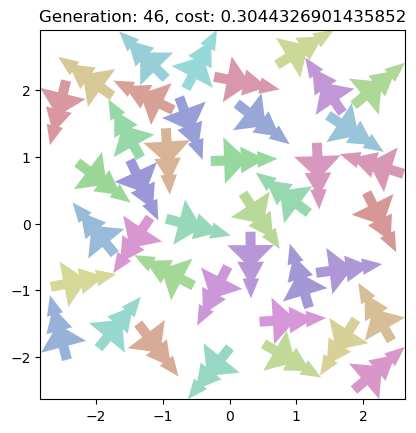

[[13], [13], [13], [13]]
Generation 47, Trees 40, Best cost: 0.30316266, Est: 0.75790668, h: 5.496442


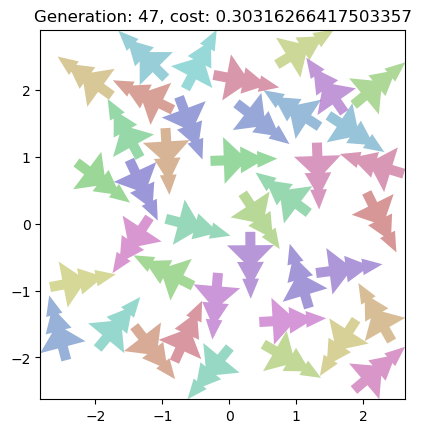

[[13], [13], [13], [13]]
Generation 48, Trees 40, Best cost: 0.30119166, Est: 0.75297914, h: 5.481662


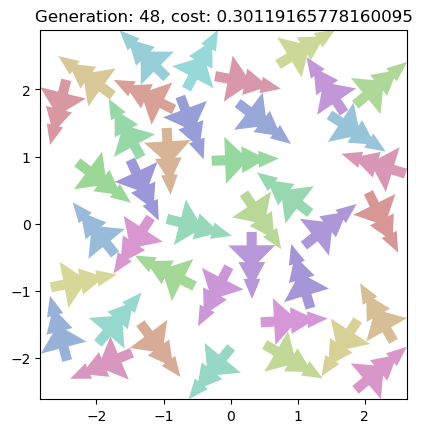

[[13], [13], [13], [13]]
Generation 49, Trees 40, Best cost: 0.29968387, Est: 0.74920969, h: 5.464993


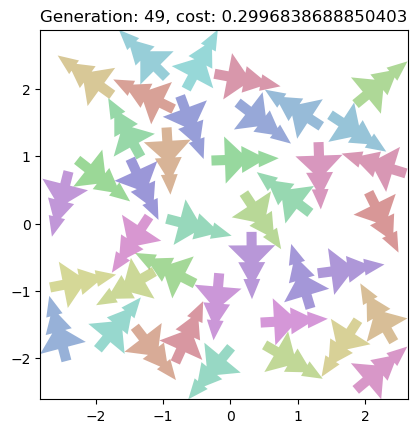

[[13], [13], [13], [13]]
Generation 50, Trees 40, Best cost: 0.29847378, Est: 0.74618444, h: 5.456866


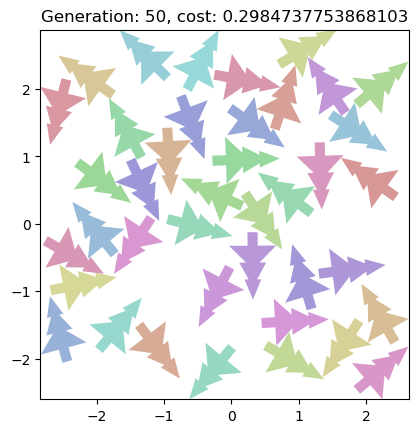

[[13], [13], [13], [13]]


In [ ]:
importlib.reload(pack_ga)
fastMode = True
runner = pack_ga.GA()
runner.N_trees_to_do = np.array([40])
if fastMode:
    runner.initializer.jiggler.duration_compact /= 10
    runner.initializer.jiggler.plot_interval = None
    runner.initializer.jiggler.n_rounds = 1    
    runner.rough_relaxers[0].n_iterations= 10
    runner.fine_relaxers = []
    runner.n_generations = 100
    runner.population_size = 100
    runner.selection_size = [1,2,5,10]
kgs.profiling=False
runner.run()
#plt.plot(runner.best_cost_per_generation)

In [ ]:
plt.plot(runner.best_cost_per_generation[:404])

In [ ]:
%debug